In [1]:
%matplotlib notebook

import numpy as np
import os
import fabio
import matplotlib.pyplot as plt
from smi_analysis import SMI_beamline, stitch

In [6]:
path = 'C:\\Users\\GF237276\\Desktop\\Projets\\Safelymove\\2023_06_19\\data_xeuss\\'
for file in os.listdir(path):
    print(file)

2023_06_19_Safelymove_0_00000.edf
2023_06_19_Safelymove_0_00001.edf
2023_06_19_Safelymove_0_00002.edf
2023_06_19_Safelymove_0_00003.edf
2023_06_19_Safelymove_0_00004.edf
2023_06_19_Safelymove_0_00005.edf
2023_06_19_Safelymove_0_00006.edf
2023_06_19_Safelymove_0_vd_00001-00002.edf
2023_06_19_Safelymove_0_vd_00003-00004.edf
2023_06_19_Safelymove_0_vd_00005-00006.edf
2023_06_19_Safelymove_1_00000.edf
2023_06_19_Safelymove_1_00001.edf
2023_06_19_Safelymove_1_00002.edf
2023_06_19_Safelymove_1_00003.edf
2023_06_19_Safelymove_1_00004.edf
2023_06_19_Safelymove_1_00005.edf
2023_06_19_Safelymove_1_00006.edf
dummy.txt
macro.mac


<IPython.core.display.Javascript object>


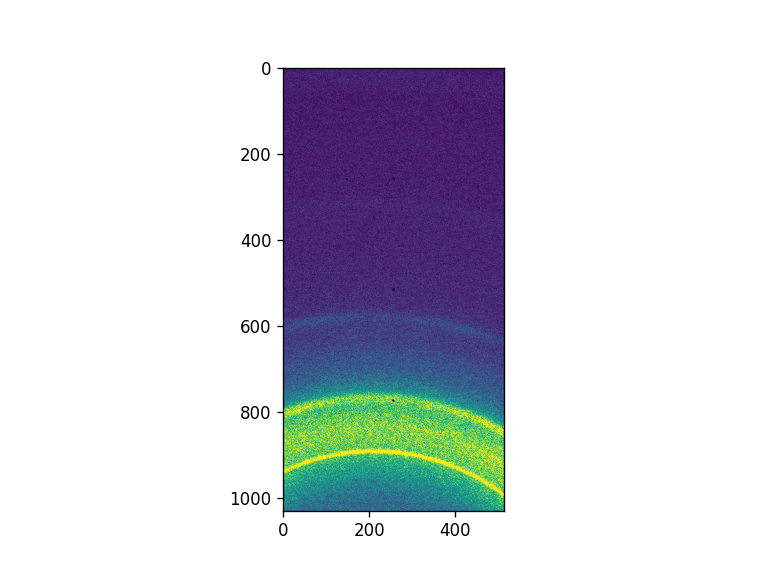

In [8]:
file = '2023_06_19_Safelymove_1_00001.edf'

img = fabio.open(os.path.join(path, file)).data

plt.figure()
plt.imshow(img, vmin=0, vmax=np.percentile(img[~np.isnan(img)], 97))
plt.show()

In [9]:
def read_header_xeuss(path, file):
    img = fabio.open(os.path.join(path, file))

    center = [float(img.header['Center_1']), float(img.header['Center_2'])]
    sdd = 1000 * float(img.header['SampleDistance'])
    wav = float(img.header['Wavelength'])

    alphai = float(img.header['phi'])  # To be checked
#     alphai = np.deg2rad(0)

    # Definition detecteur
    gamma = float(img.header['Gamma'])
    delta = float(img.header['Delta'])
    rot1 = -np.deg2rad(gamma)
    rot2 = np.deg2rad(delta)
    rot3 = 0
#     print(center)

    return sdd, wav, alphai, center, rot1, rot2, rot3

sdd, wav, alphai, center, rot1, rot2, rot3 = read_header_xeuss(path, file)

In [7]:
-np.deg2rad(25)

-0.4363323129985824

### Test on one file

In [10]:
file = ['2023_06_19_Safelymove_1_00001.edf']

for i, files in enumerate(file):
    if i==0:
        rot_all = []
        center_all = []
        sdd_all = []
    sdd, wav, alphai, center, rot1, rot2, rot3 = read_header_xeuss(path, files)
    center_all = center_all + [center]
    rot_all = rot_all + [[rot1, rot2, rot3]]
    sdd_all = sdd_all + [sdd]

In [11]:
np.rad2deg(rot_all)

array([[ 0.8     , -0.999903,  0.      ]])

<IPython.core.display.Javascript object>


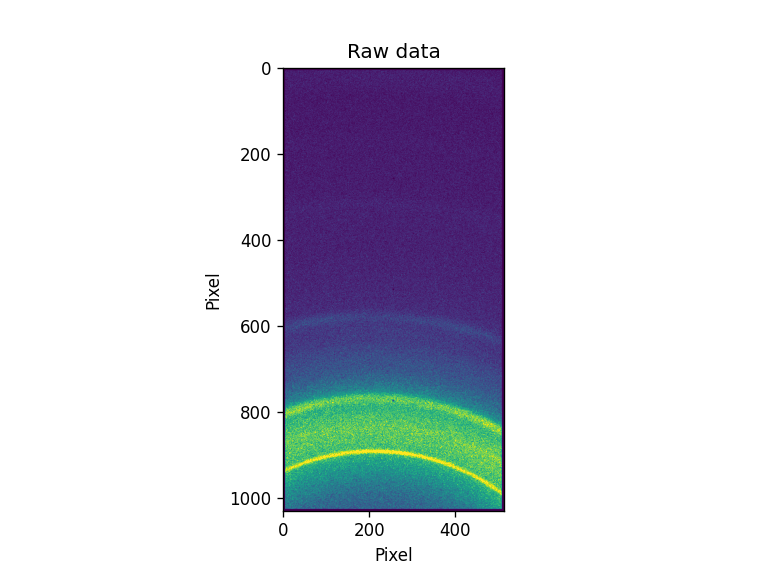

<IPython.core.display.Javascript object>


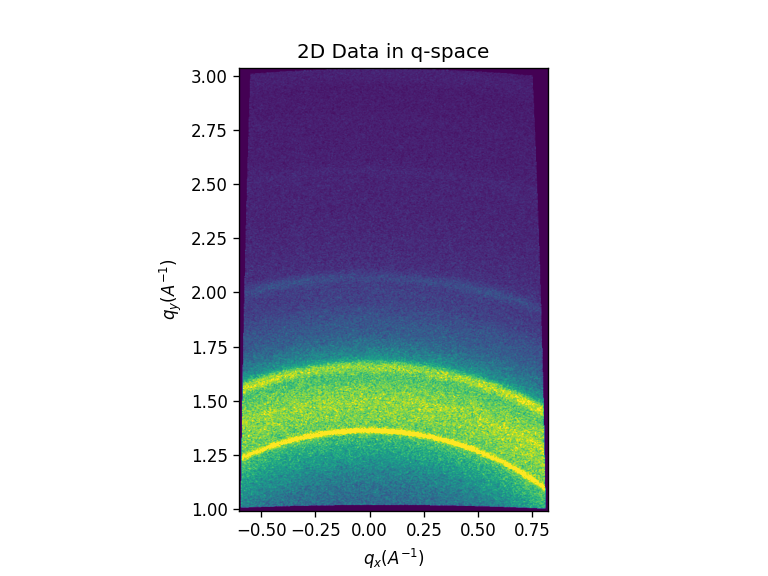

<IPython.core.display.Javascript object>


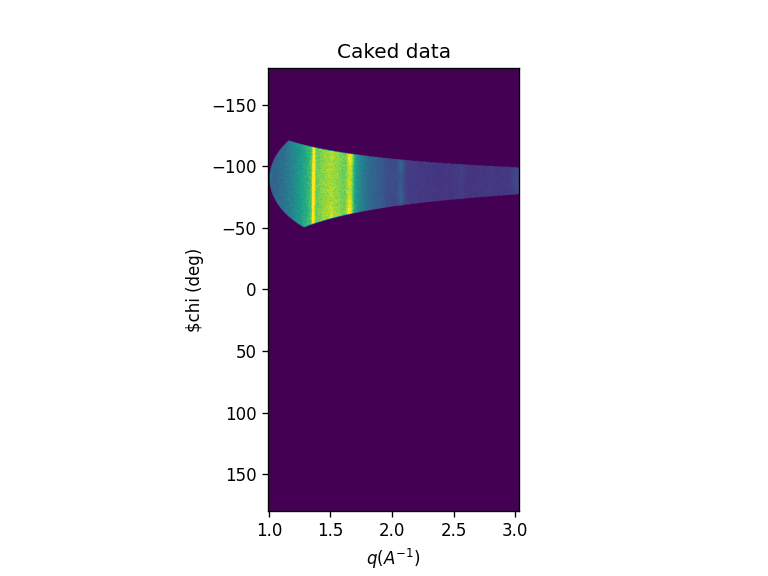

<IPython.core.display.Javascript object>


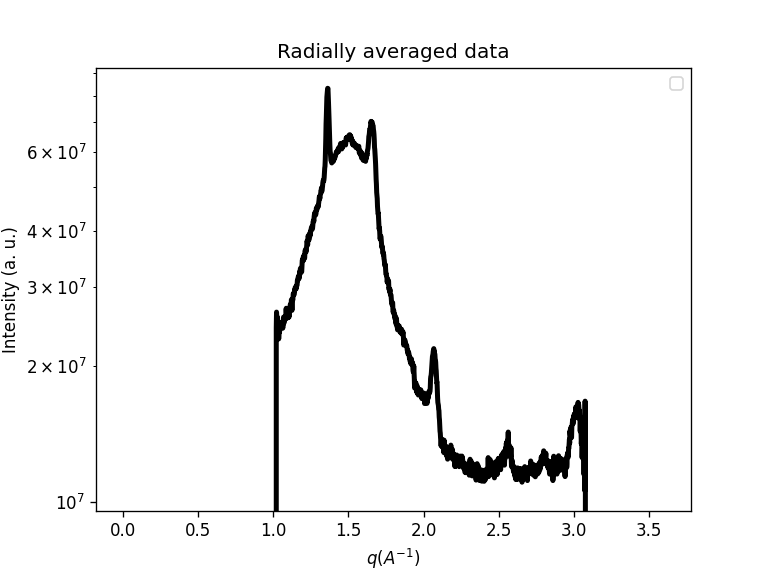

In [12]:
file = ['2023_06_19_Safelymove_1_00001.edf']

geometry = 'Transmission'
bs_pos_waxs = [[0,0]]
detector_waxs = 'Eiger1M_xeuss'

SMI_waxs = SMI_beamline.SMI_geometry(geometry=geometry,
                                    sdd=sdd_all,
                                    wav=wav,
                                    alphai=alphai,
                                    center=center_all,
                                    bs_pos=bs_pos_waxs,
                                    detector=detector_waxs,
                                    det_angles=rot_all)

SMI_waxs.open_data(path, file)
SMI_waxs.imgs[0] += fabio.open(os.path.join(path, '2023_06_19_Safelymove_1_00002.edf')).data

plt.figure()
plt.title('Raw data')
for i, img in enumerate(SMI_waxs.imgs):
    plt.subplot(1, len(file), i+1)
    plt.imshow(SMI_waxs.imgs[i]*np.logical_not(SMI_waxs.masks[i]),
            vmin=0,
            vmax=abs(np.percentile(SMI_waxs.imgs[i], 99)))
plt.xlabel('Pixel')
plt.ylabel('Pixel')
# plt.colorbar()
plt.show()


SMI_waxs.stitching_data(flag_scale=False)

plt.figure()
plt.title('2D Data in q-space')
plt.imshow(SMI_waxs.img_st,
            extent=[min(SMI_waxs.qp), max(SMI_waxs.qp), SMI_waxs.qz[0], SMI_waxs.qz[-1]],
            vmin=0,
            vmax=np.percentile(SMI_waxs.img_st[~np.isnan(SMI_waxs.img_st)], 99))
plt.xlabel('$q_{x} (A^{-1}$)')
plt.ylabel('$q_{y} (A^{-1}$)')
plt.show()
        
        

SMI_waxs.caking(azimuth_range=[-180, 180], radial_range=[min(SMI_waxs.qz), max(SMI_waxs.qz)], npt_rad=1000, npt_azim=1000)

plt.figure()
plt.title('Caked data')
plt.imshow(SMI_waxs.cake,
           extent=[SMI_waxs.q_cake[0], SMI_waxs.q_cake[-1], SMI_waxs.chi_cake[0], SMI_waxs.chi_cake[-1]],
           vmin=0,
           vmax=np.percentile(SMI_waxs.cake[~np.isnan(SMI_waxs.cake)], 99.8),
           aspect=0.01)
plt.xlabel('$q (A^{-1}$)')
plt.ylabel('$chi (deg)')
plt.show()


SMI_waxs.radial_averaging(radial_range=[0, 3.6], azimuth_range=[-180, 0], npt=2000)
qs1, Is1 = SMI_waxs.q_rad, SMI_waxs.I_rad

plt.figure()
plt.title('Radially averaged data')
plt.plot(qs1, Is1, linewidth=3, color='k')
plt.yscale('log')
plt.legend()
plt.xlabel('$q (A^{-1}$)')
plt.ylabel('Intensity (a. u.)')
plt.show()

<IPython.core.display.Javascript object>


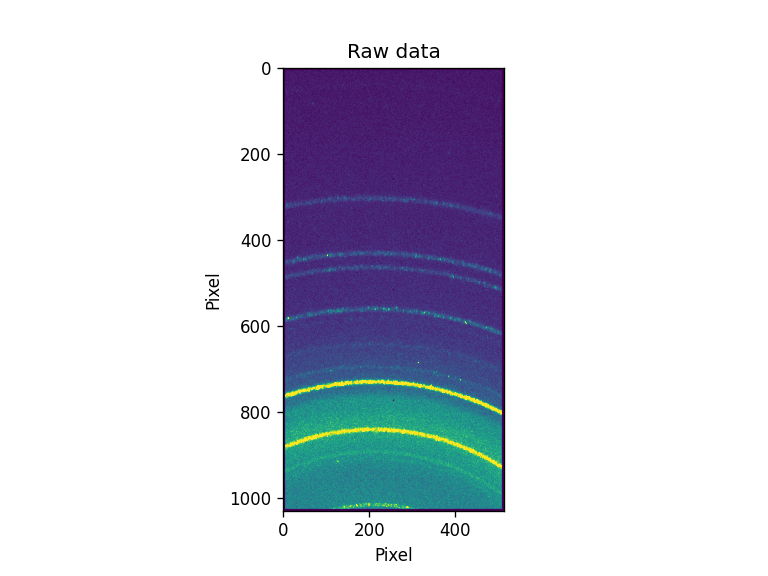

<IPython.core.display.Javascript object>


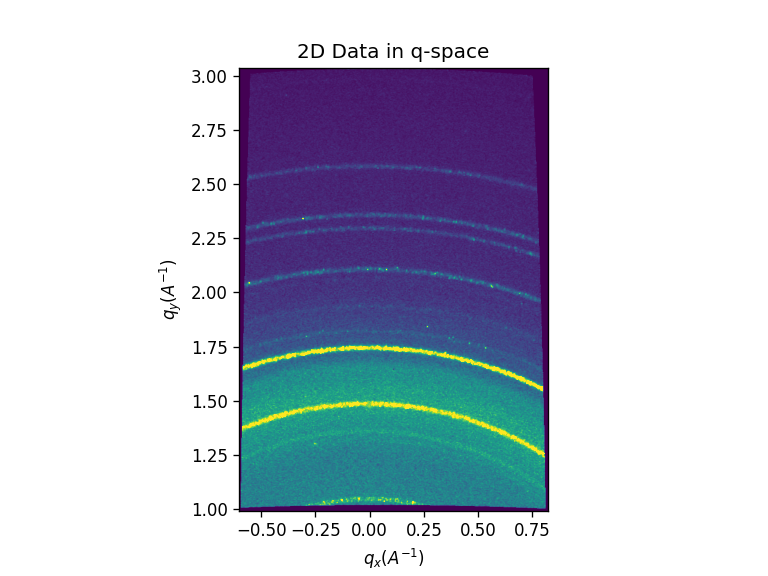

<IPython.core.display.Javascript object>


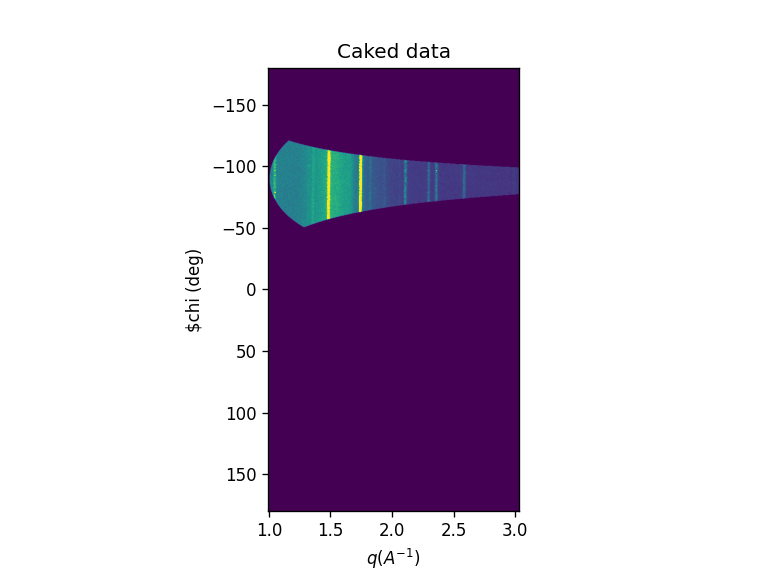

<IPython.core.display.Javascript object>


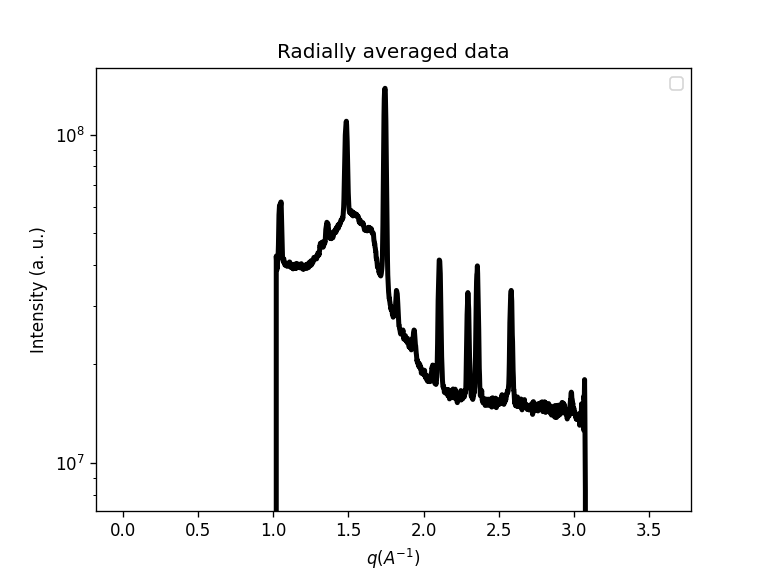

In [17]:
file = ['2023_06_19_Safelymove_1_00003.edf']

geometry = 'Transmission'
bs_pos_waxs = [[0,0]]
detector_waxs = 'Eiger1M_xeuss'

SMI_waxs = SMI_beamline.SMI_geometry(geometry=geometry,
                                    sdd=sdd_all,
                                    wav=wav,
                                    alphai=alphai,
                                    center=center_all,
                                    bs_pos=bs_pos_waxs,
                                    detector=detector_waxs,
                                    det_angles=rot_all)

SMI_waxs.open_data(path, file)
SMI_waxs.imgs[0] += fabio.open(os.path.join(path, '2023_06_19_Safelymove_1_00004.edf')).data

plt.figure()
plt.title('Raw data')
for i, img in enumerate(SMI_waxs.imgs):
    plt.subplot(1, len(file), i+1)
    plt.imshow(SMI_waxs.imgs[i]*np.logical_not(SMI_waxs.masks[i]),
            vmin=0,
            vmax=abs(np.percentile(SMI_waxs.imgs[i], 99)))
plt.xlabel('Pixel')
plt.ylabel('Pixel')
# plt.colorbar()
plt.show()


SMI_waxs.stitching_data(flag_scale=False)

plt.figure()
plt.title('2D Data in q-space')
plt.imshow(SMI_waxs.img_st,
            extent=[min(SMI_waxs.qp), max(SMI_waxs.qp), SMI_waxs.qz[0], SMI_waxs.qz[-1]],
            vmin=0,
            vmax=np.percentile(SMI_waxs.img_st[~np.isnan(SMI_waxs.img_st)], 99))
plt.xlabel('$q_{x} (A^{-1}$)')
plt.ylabel('$q_{y} (A^{-1}$)')
plt.show()
        
        

SMI_waxs.caking(azimuth_range=[-180, 180], radial_range=[min(SMI_waxs.qz), max(SMI_waxs.qz)], npt_rad=1000, npt_azim=1000)

plt.figure()
plt.title('Caked data')
plt.imshow(SMI_waxs.cake,
           extent=[SMI_waxs.q_cake[0], SMI_waxs.q_cake[-1], SMI_waxs.chi_cake[0], SMI_waxs.chi_cake[-1]],
           vmin=0,
           vmax=np.percentile(SMI_waxs.cake[~np.isnan(SMI_waxs.cake)], 99.8),
           aspect=0.01)
plt.xlabel('$q (A^{-1}$)')
plt.ylabel('$chi (deg)')
plt.show()


SMI_waxs.radial_averaging(radial_range=[0, 3.6], azimuth_range=[-180, 0], npt=2000)
qs2, Is2 = SMI_waxs.q_rad, SMI_waxs.I_rad

plt.figure()
plt.title('Radially averaged data')
plt.plot(qs2, Is2, linewidth=3, color='k')
plt.yscale('log')
plt.legend()
plt.xlabel('$q (A^{-1}$)')
plt.ylabel('Intensity (a. u.)')
plt.show()

<IPython.core.display.Javascript object>


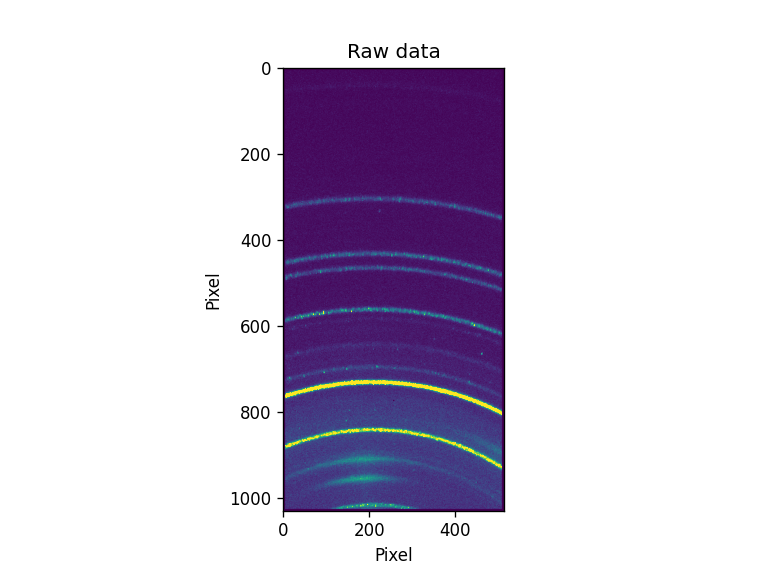

<IPython.core.display.Javascript object>


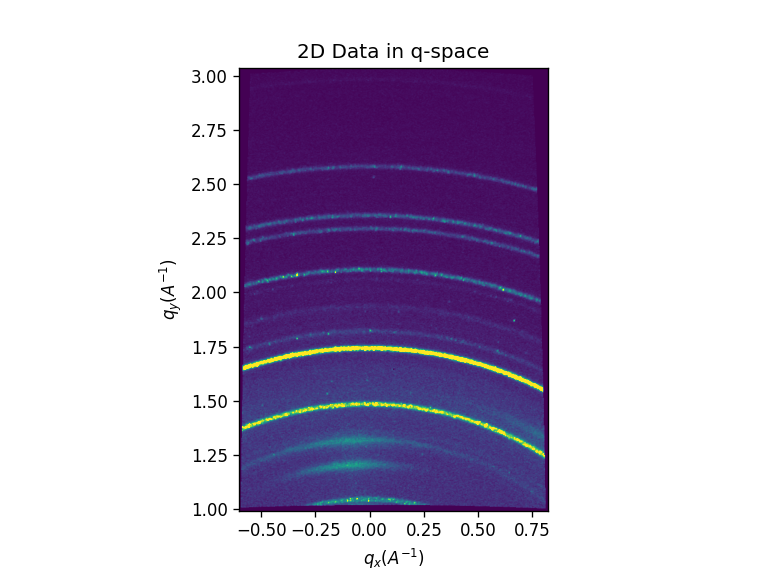

C:\Users\GF237276\AppData\Local\Temp\ipykernel_8332\853891676.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


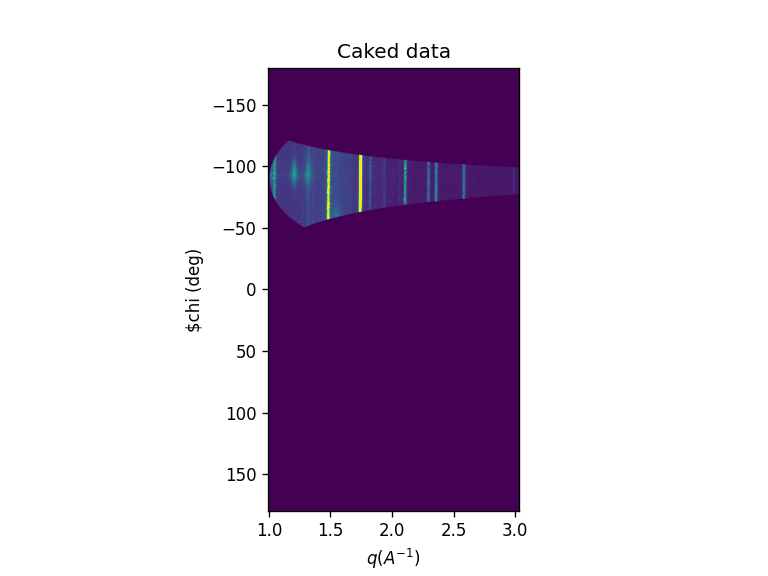

<IPython.core.display.Javascript object>


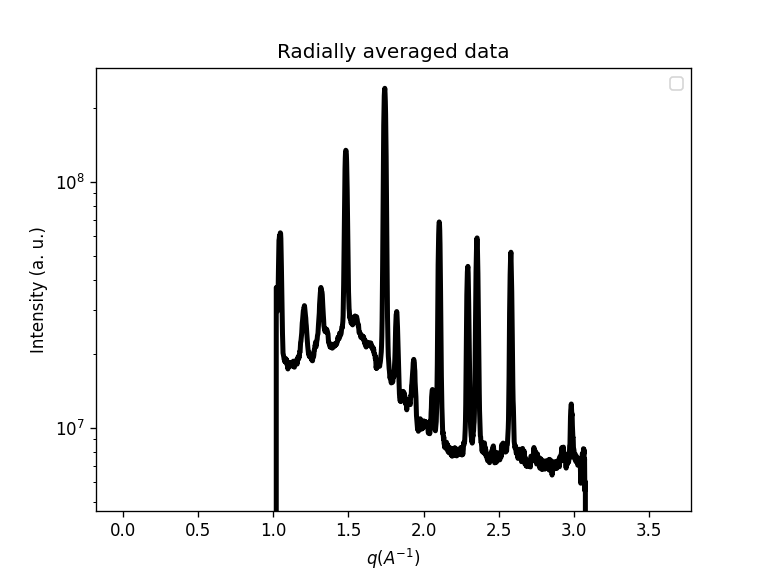

In [16]:
file = ['2023_06_19_Safelymove_1_00005.edf']

geometry = 'Transmission'
bs_pos_waxs = [[0,0]]
detector_waxs = 'Eiger1M_xeuss'

SMI_waxs = SMI_beamline.SMI_geometry(geometry=geometry,
                                    sdd=sdd_all,
                                    wav=wav,
                                    alphai=alphai,
                                    center=center_all,
                                    bs_pos=bs_pos_waxs,
                                    detector=detector_waxs,
                                    det_angles=rot_all)

SMI_waxs.open_data(path, file)
SMI_waxs.imgs[0] += fabio.open(os.path.join(path, '2023_06_19_Safelymove_1_00006.edf')).data

plt.figure()
plt.title('Raw data')
for i, img in enumerate(SMI_waxs.imgs):
    plt.subplot(1, len(file), i+1)
    plt.imshow(SMI_waxs.imgs[i]*np.logical_not(SMI_waxs.masks[i]),
            vmin=0,
            vmax=abs(np.percentile(SMI_waxs.imgs[i], 99)))
plt.xlabel('Pixel')
plt.ylabel('Pixel')
# plt.colorbar()
plt.show()


SMI_waxs.stitching_data(flag_scale=False)

plt.figure()
plt.title('2D Data in q-space')
plt.imshow(SMI_waxs.img_st,
            extent=[min(SMI_waxs.qp), max(SMI_waxs.qp), SMI_waxs.qz[0], SMI_waxs.qz[-1]],
            vmin=0,
            vmax=np.percentile(SMI_waxs.img_st[~np.isnan(SMI_waxs.img_st)], 99))
plt.xlabel('$q_{x} (A^{-1}$)')
plt.ylabel('$q_{y} (A^{-1}$)')
plt.show()
        
        

SMI_waxs.caking(azimuth_range=[-180, 180], radial_range=[min(SMI_waxs.qz), max(SMI_waxs.qz)], npt_rad=1000, npt_azim=1000)

plt.figure()
plt.title('Caked data')
plt.imshow(SMI_waxs.cake,
           extent=[SMI_waxs.q_cake[0], SMI_waxs.q_cake[-1], SMI_waxs.chi_cake[0], SMI_waxs.chi_cake[-1]],
           vmin=0,
           vmax=np.percentile(SMI_waxs.cake[~np.isnan(SMI_waxs.cake)], 99.8),
           aspect=0.01)
plt.xlabel('$q (A^{-1}$)')
plt.ylabel('$chi (deg)')
plt.show()


SMI_waxs.radial_averaging(radial_range=[0, 3.6], azimuth_range=[-180, 0], npt=2000)
qs3, Is3 = SMI_waxs.q_rad, SMI_waxs.I_rad

plt.figure()
plt.title('Radially averaged data')
plt.plot(qs3, Is3, linewidth=3, color='k')
plt.yscale('log')
plt.legend()
plt.xlabel('$q (A^{-1}$)')
plt.ylabel('Intensity (a. u.)')
plt.show()

<IPython.core.display.Javascript object>


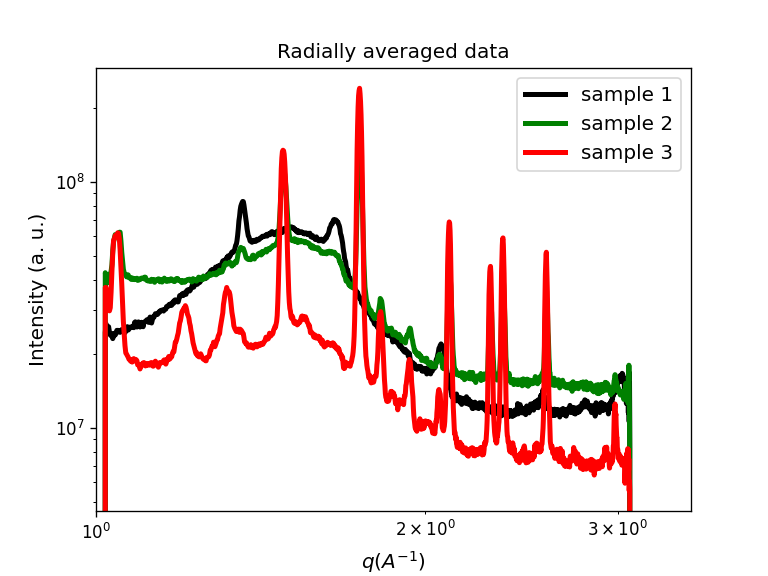

In [20]:
plt.figure()
plt.title('Radially averaged data', fontsize=12)
plt.plot(qs1, Is1, linewidth=3, color='k', label='sample 1')
plt.plot(qs2, Is2, linewidth=3, color='g', label='sample 2')
plt.plot(qs3, Is3, linewidth=3, color='r', label='sample 3')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$q (A^{-1}$)', fontsize=12)
plt.ylabel('Intensity (a. u.)', fontsize=12)
plt.legend(fontsize=12)
plt.xlim([1, 3.5])
plt.show()
